<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/11_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 11 - Solution

# Install

In [1]:
!pip install geopandas
!pip install rtree
!pip install contextily

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 38.0 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas
import contextily as ctx

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from mpl_toolkits.axes_grid1 import make_axes_locatable

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Geography

## Crash Data

In [3]:
!wget -O crash.json https://data.townofcary.org/api/v2/catalog/datasets/cpd-crash-incidents/exports/geojson 

--2021-09-30 09:09:31--  https://data.townofcary.org/api/v2/catalog/datasets/cpd-crash-incidents/exports/geojson
Resolving data.townofcary.org (data.townofcary.org)... 52.1.105.32, 34.196.27.91
Connecting to data.townofcary.org (data.townofcary.org)|52.1.105.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘crash.json’

crash.json              [                <=> ]  28.87M  1.56MB/s    in 19s     

2021-09-30 09:09:51 (1.50 MB/s) - ‘crash.json’ saved [30274938]



In [4]:
crash_df = geopandas.read_file('crash.json')

In [5]:
crash_df.dtypes

vehicle4                  object
tract                     object
month                     object
weather                   object
fatalities                object
numpassengers            float64
year                      object
ta_date                   object
zone                      object
vehicle1                  object
vehicle2                  object
vehicle3                  object
lon                      float64
vehicle5                  object
injuries                  object
geo_location              object
trafcontrl                object
ta_time                   object
contrcir4_desc            object
vehicleconcat2            object
vehicleconcat3            object
tamainid                   int64
numpedestrians            object
rdcondition               object
contrcir2_desc            object
lightcond                 object
contrcir3_desc            object
records                    int64
contrfact2                object
fatality                   int64
contrfact1

In [6]:
crash_df[['lat', 'lon', 'month', 'weather', 'vehicle1', 'geometry']]

,lat,lon,month,weather,vehicle1,geometry
0,NaN,NaN,3,CLOUDY,SPORT UTILITY,None
1,35.781175,-78.780414,3,CLEAR,SPORT UTILITY,POINT (-78.78041 35.78118)
2,NaN,NaN,3,CLEAR,PASSENGER CAR,None
3,NaN,NaN,3,CLEAR,PASSENGER CAR,None
4,NaN,NaN,3,CLEAR,SPORT UTILITY,None
...,...,...,...,...,...,...
25576,NaN,NaN,6,CLEAR,PASSENGER CAR,None
25577,35.792979,-78.748970,6,CLOUDY,PASSENGER CAR,POINT (-78.74897 35.79298)
25578,35.782693,-78.850163,6,CLEAR,PASSENGER CAR,POINT (-78.85016 35.78269)
25579,NaN,NaN,6,CLEAR,None,None


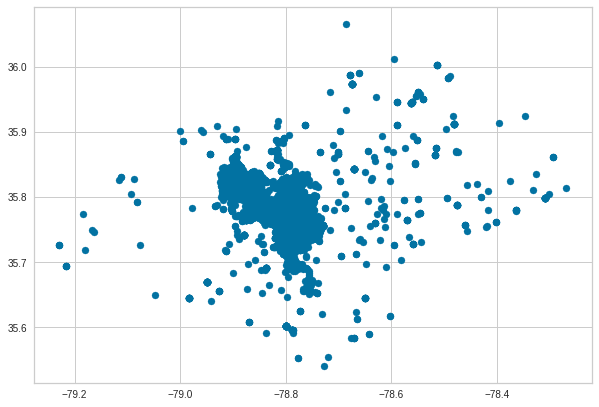

In [7]:
# Plot Crashes
crash_df.plot(figsize=(10, 10))

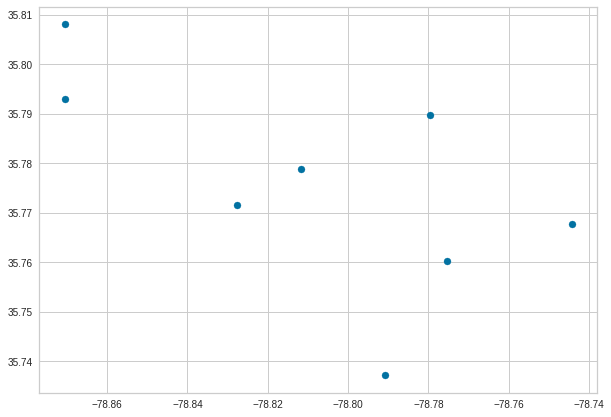

In [8]:
# Plot Fatalities (fatality field)
crash_df[crash_df.fatality > 0].plot(figsize=(10, 10))

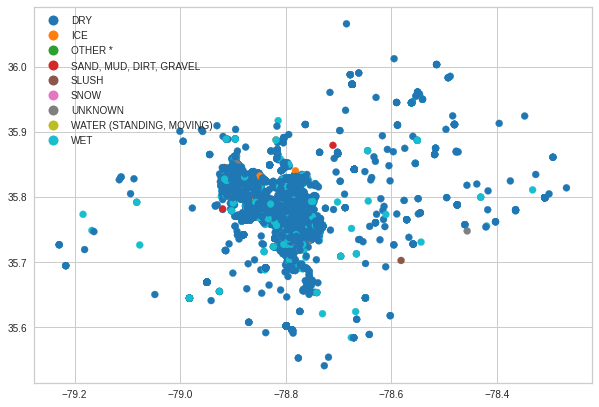

In [9]:
# Plot & color by Road Conditions (rdcondition) on map
crash_df.plot(column='rdcondition', figsize=(10, 10), legend=True)

## Residential Zones

In [10]:
!wget -O zones.json https://data.townofcary.org/explore/dataset/httpmapstownofcary0/download/?format=geojson&timezone=America/New_York&lang=en

--2021-09-30 09:10:01--  https://data.townofcary.org/explore/dataset/httpmapstownofcary0/download/?format=geojson
Resolving data.townofcary.org (data.townofcary.org)... 52.1.105.32, 34.196.27.91
Connecting to data.townofcary.org (data.townofcary.org)|52.1.105.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘zones.json’

zones.json              [ <=>                ]   2.67M  --.-KB/s    in 0.1s    

2021-09-30 09:10:02 (18.3 MB/s) - ‘zones.json’ saved [2800775]



In [11]:
zones_df = geopandas.read_file('zones.json')

In [12]:
zones_df = zones_df.dropna()
zones_df = zones_df[zones_df.approvedlots > 0]

In [13]:
zones_df.dtypes

category            object
name                object
shape_stlength     float64
shape_starea       float64
approvedlots       float64
description         object
geometry          geometry
dtype: object

In [14]:
zones_df

,category,name,shape_stlength,shape_starea,approvedlots,description,geometry
0,Single-Family Detached,Rockhampton,2373.790731,2.834586e+05,19.0,Single-Family Detached,"POLYGON ((-78.82404 35.76970, -78.82397 35.770..."
1,Single-Family Detached,Excalibur,4690.841435,1.159536e+06,90.0,Single-Family Detached,"POLYGON ((-78.84445 35.78087, -78.84470 35.780..."
2,Single-Family Detached,South Chase,5212.223207,1.449369e+06,73.0,Single-Family Detached,"POLYGON ((-78.81382 35.71970, -78.81190 35.719..."
3,Single-Family Detached,"Coventry, The",3293.952572,5.049963e+05,31.0,Single-Family Detached,"POLYGON ((-78.78127 35.75382, -78.78128 35.753..."
4,Single-Family Detached,Cheverly Forest,3527.454496,5.721622e+05,54.0,Single-Family Detached,"POLYGON ((-78.80252 35.76355, -78.80213 35.763..."
...,...,...,...,...,...,...,...
714,Single-Family Detached,Bud El Acres,5837.079271,1.001130e+06,28.0,Single-Family Detached,"POLYGON ((-78.80257 35.80148, -78.80254 35.801..."
715,Single-Family Detached,Wynwood South,3668.841994,6.146209e+05,42.0,Single-Family Detached,"POLYGON ((-78.75224 35.75551, -78.75300 35.753..."
716,Single-Family Detached,Oaks at Sears Farm Subdivision (North),1869.206667,2.133838e+05,16.0,Single-Family Detached,"POLYGON ((-78.87812 35.80269, -78.87857 35.802..."
717,Single-Family Detached,Garden Ridge,1602.020885,1.581953e+05,7.0,Single-Family Detached,"POLYGON ((-78.89792 35.78826, -78.89792 35.789..."


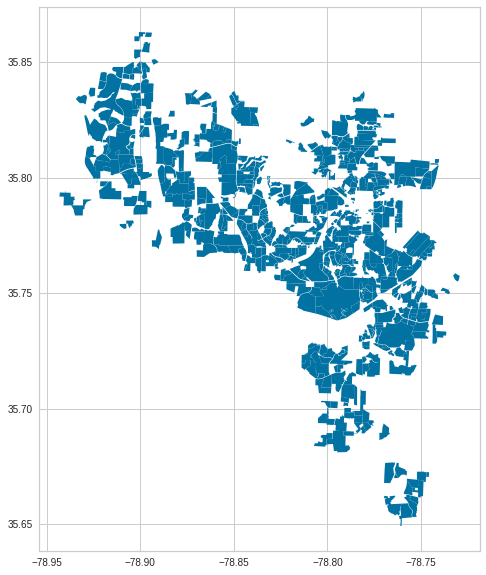

In [15]:
zones_df.plot(figsize=(10, 10))

In [16]:
# Plot zones, color by number of lots (shape_starea / approvedlots)
zones_df['density'] = zones_df.shape_starea / zones_df.approvedlots
zones_df['density'] = (zones_df.density - zones_df.density.mean()) / zones_df.density.std()
zones_df

,category,name,shape_stlength,shape_starea,approvedlots,description,geometry,density
0,Single-Family Detached,Rockhampton,2373.790731,2.834586e+05,19.0,Single-Family Detached,"POLYGON ((-78.82404 35.76970, -78.82397 35.770...",-0.135354
1,Single-Family Detached,Excalibur,4690.841435,1.159536e+06,90.0,Single-Family Detached,"POLYGON ((-78.84445 35.78087, -78.84470 35.780...",-0.236953
2,Single-Family Detached,South Chase,5212.223207,1.449369e+06,73.0,Single-Family Detached,"POLYGON ((-78.81382 35.71970, -78.81190 35.719...",0.111039
3,Single-Family Detached,"Coventry, The",3293.952572,5.049963e+05,31.0,Single-Family Detached,"POLYGON ((-78.78127 35.75382, -78.78128 35.753...",-0.066893
4,Single-Family Detached,Cheverly Forest,3527.454496,5.721622e+05,54.0,Single-Family Detached,"POLYGON ((-78.80252 35.76355, -78.80213 35.763...",-0.351183
...,...,...,...,...,...,...,...,...
714,Single-Family Detached,Bud El Acres,5837.079271,1.001130e+06,28.0,Single-Family Detached,"POLYGON ((-78.80257 35.80148, -78.80254 35.801...",0.904824
715,Single-Family Detached,Wynwood South,3668.841994,6.146209e+05,42.0,Single-Family Detached,"POLYGON ((-78.75224 35.75551, -78.75300 35.753...",-0.149584
716,Single-Family Detached,Oaks at Sears Farm Subdivision (North),1869.206667,2.133838e+05,16.0,Single-Family Detached,"POLYGON ((-78.87812 35.80269, -78.87857 35.802...",-0.214351
717,Single-Family Detached,Garden Ridge,1602.020885,1.581953e+05,7.0,Single-Family Detached,"POLYGON ((-78.89792 35.78826, -78.89792 35.789...",0.248075


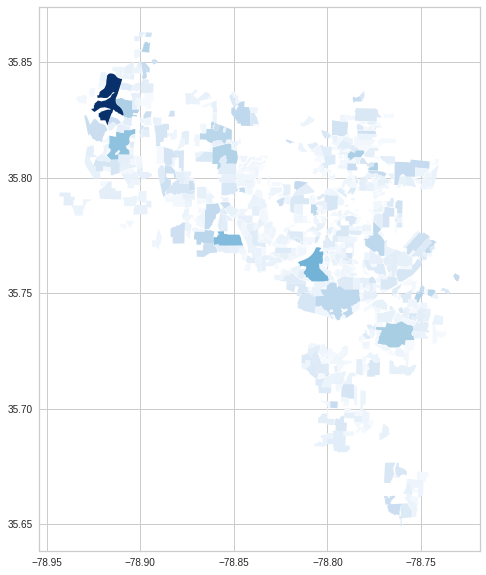

In [17]:
# Plot zones, color by density (approvedlots)
zones_df.plot(column='approvedlots', figsize=(10, 10), cmap='Blues')

## Joining

In [18]:
# Spatial Join - Crashes to Residential Zones
within_df = geopandas.sjoin(zones_df, crash_df, how="inner", op='contains')
within_df

,category,name,shape_stlength,shape_starea,approvedlots,description,geometry,density,index_right,vehicle4,tract,month,weather,fatalities,numpassengers,year,ta_date,zone,vehicle1,vehicle2,vehicle3,lon,vehicle5,injuries,geo_location,trafcontrl,ta_time,contrcir4_desc,vehicleconcat2,vehicleconcat3,tamainid,numpedestrians,rdcondition,contrcir2_desc,lightcond,contrcir3_desc,records,contrfact2,fatality,contrfact1,lat,crash_date,possblinj,rdsurface,rdfeature,lat2,contrcir1_desc,location_description,vehicleconcat1,lon2,workarea
1,Single-Family Detached,Excalibur,4690.841435,1.159536e+06,90.0,Single-Family Detached,"POLYGON ((-78.84445 35.78087, -78.84470 35.780...",-0.236953,12219,None,P066,4,CLEAR,No,2.0,2017,2017-04-27,117,PASSENGER CAR,SPORT UTILITY,None,-78.847902,None,No,None,NO CONTROL PRESENT,07:37:48,None,"PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY",28911,None,DRY,None,DAYLIGHT,NONE,6285,"NONE,NONE",0,NONE,35.780738,1493293068,0,SMOOTH ASPHALT,NO SPECIAL FEATURE,35.781100,NONE,369 FEET FROM SWORDGATE DR,"PASSENGER CAR,SPORT UTILITY",-78.847700,NO
2,Single-Family Detached,South Chase,5212.223207,1.449369e+06,73.0,Single-Family Detached,"POLYGON ((-78.81382 35.71970, -78.81190 35.719...",0.111039,13337,None,P043,4,RAIN,No,NaN,2020,2020-04-09,116,PASSENGER CAR,PASSENGER CAR,None,-78.810831,None,No,None,NO CONTROL PRESENT,08:19:21,None,"PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR",44372,None,WET,None,DAWN,NONE,20745,"NONE,NONE",0,NONE,35.718336,1586434761,0,SMOOTH ASPHALT,NO SPECIAL FEATURE,35.718300,NONE,300 FEET FROM ARBORDALE CT,"PASSENGER CAR,PASSENGER CAR",-78.810800,NO
2,Single-Family Detached,South Chase,5212.223207,1.449369e+06,73.0,Single-Family Detached,"POLYGON ((-78.81382 35.71970, -78.81190 35.719...",0.111039,17050,None,P043,6,RAIN,No,NaN,2020,2020-06-15,116,PASSENGER CAR,PASSENGER CAR,None,-78.810831,None,No,None,NO CONTROL PRESENT,10:57:00,None,"PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR",44808,None,WET,None,DAYLIGHT,NONE,21181,"NONE,NONE",0,NONE,35.718336,1592233020,0,SMOOTH ASPHALT,"DRIVEWAY, PRIVATE",35.719642,NONE,.15 MILES FROM ARBORDALE CT,"PASSENGER CAR,PASSENGER CAR",-78.809861,NO
3,Single-Family Detached,"Coventry, The",3293.952572,5.049963e+05,31.0,Single-Family Detached,"POLYGON ((-78.78127 35.75382, -78.78128 35.753...",-0.066893,8998,None,P005,11,CLEAR,No,NaN,2020,2020-11-06,115,LIGHT TRUCK (MINI-VAN- PANEL),LIGHT TRUCK (MINI-VAN- PANEL),None,-78.782107,None,No,None,NO CONTROL PRESENT,08:49:02,None,"LIGHT TRUCK (MINI-VAN- PANEL),LIGHT TRUCK (MIN...","LIGHT TRUCK (MINI-VAN- PANEL),LIGHT TRUCK (MIN...",45974,None,DRY,None,DAYLIGHT,NONE,22346,"NONE,NONE",0,NONE,35.752966,1604670542,0,SMOOTH ASPHALT,NO SPECIAL FEATURE,35.752584,NONE,.02 MILES FROM KETTERING LN,"LIGHT TRUCK (MINI-VAN- PANEL),LIGHT TRUCK (MIN...",-78.781753,NO
6,Single-Family Detached,Oakwood Heights,8875.000065,4.315995e+06,230.0,Single-Family Detached,"POLYGON ((-78.80156 35.79028, -78.80155 35.790...",0.056665,19420,None,P026,9,CLEAR,No,NaN,2021,2021-09-01,114,PASSENGER CAR,PASSENGER CAR,None,-78.799755,None,No,None,NO CONTROL PRESENT,02:46:24,None,"PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR",48901,None,DRY,None,DARK - LIGHTED ROADWAY,NONE,25271,NONE,0,None,35.792092,1630478784,0,SMOOTH ASPHALT,NO SPECIAL FEATURE,35.792808,None,300 FEET FROM MADISON AV,"PASSENGER CAR,PASSENGER CAR",-78.799342,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,Single-Family Detached,Bud El Acres,5837.079271,1.001130e+06,28.0,Single-Family Detached,"POLYGON ((-78.80257 35.80148, -78.80254 35.801...",0.904824,14636,None,P023,11,CLEAR,No,NaN,2019,2019-11-10,111,PICKUP,PASSENGER CAR,None,-78.801632,None,No,None,NO CONTROL PRESENT,12:11:00,None,"PICKUP,PASSENGER CAR","PICKUP,PASSENGER CAR",42732,None,DRY,None,DAYLIGHT,NONE,19107,"NONE,NONE",0,

In [19]:
# Find top 10 zones with crashes using groupby
top10 = within_df.groupby('name').size().sort_values(ascending=False).head(10)
top10

name
Mobile Estates                  37
Wellsley                        29
Carolina Preserve at Amberly    29
Russell Hills                   26
Cary Park                       23
Irongate                        23
Briarcliff                      21
Scottish Hills                  21
Seal Harbor At Twin Lakes       20
Carpenter Village               18
dtype: int64

In [20]:
# Change Projection to EPSG:3857
within_df = within_df.to_crs(epsg=3857)

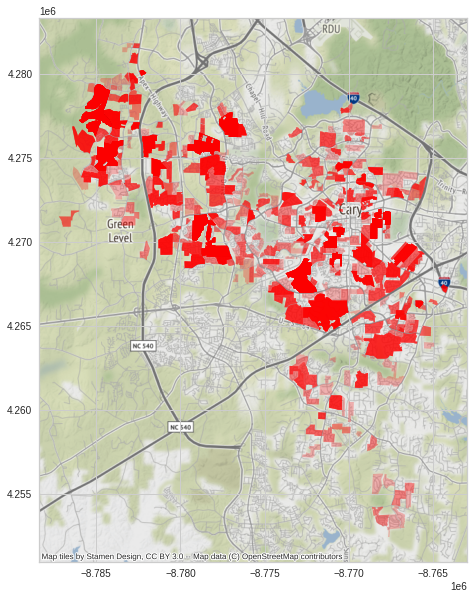

In [21]:
# Plot with basemap
ax = within_df.plot(figsize=(10, 10), alpha=0.25, color='red')
ctx.add_basemap(ax)

# Clustering

## Data

In [22]:
boston = load_boston()
boston_df = pd.DataFrame(boston['data']) 
boston_df.columns = boston['feature_names']
boston_df['PRICE'] = boston['target']
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


## Preprocessing

In [23]:
# Grab Price and Age
cluster_df = boston_df[['PRICE', 'INDUS']].copy()

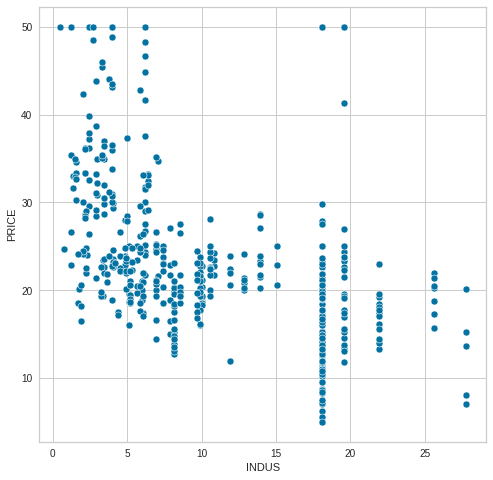

In [24]:
# Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=cluster_df.INDUS, y=cluster_df.PRICE)

In [25]:
# Standardize
ct = ColumnTransformer([
        ('standardize', StandardScaler(), ['PRICE', 'INDUS'])
    ], remainder='passthrough')
transformed = ct.fit_transform(cluster_df)
transformed

array([[ 0.15968566, -1.2879095 ],
       [-0.10152429, -0.59338101],
       [ 1.32424667, -0.59338101],
       ...,
       [ 0.14880191,  0.11573841],
       [-0.0579893 ,  0.11573841],
       [-1.15724782,  0.11573841]])

## Cluster

In [26]:
# Run KMeans of 3 clusters
cluster = KMeans(n_clusters=3)
fitted = cluster.fit(transformed)

In [27]:
# Get the assigned clusters
assignment = fitted.predict(transformed)
assignment

array([0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0,

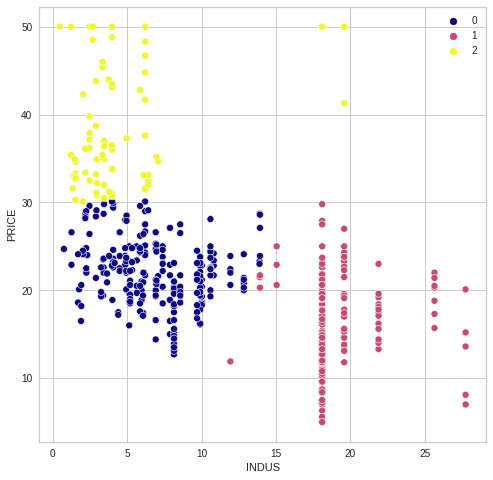

In [28]:
# Plot clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(x='INDUS', y='PRICE', data=cluster_df, hue=assignment, palette='plasma')

## Find K

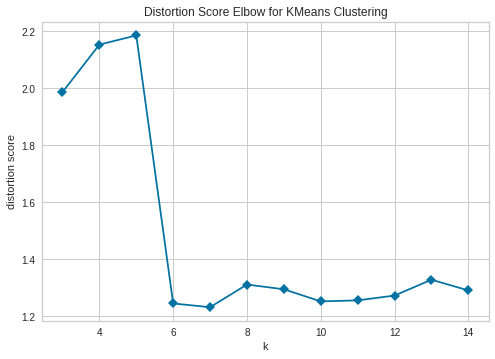

In [29]:
# Use Yellowbrick to find an optimal number of clusters between 3 and 15
model = KMeans()
visualizer = KElbowVisualizer(model, k=[x for x in range(3, 15)], timings=False)

visualizer.fit(transformed) # Fit the data to the visualizer
visualizer.poof()           # Finalize and render the figure

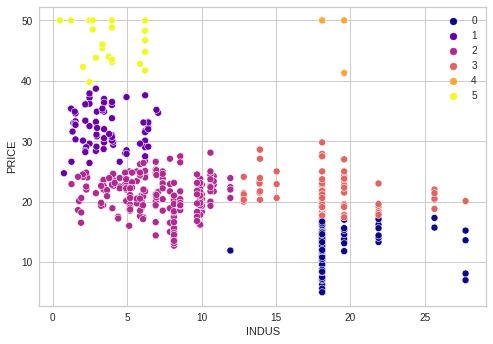

In [30]:
# Cluster and plot at the elbow
cluster = KMeans(n_clusters=6)
fitted = cluster.fit(transformed)
assignment = fitted.predict(transformed)
sns.scatterplot(x='INDUS', y='PRICE', data=cluster_df, hue=assignment, palette='plasma')